# Random Variables

In the following sections we illustrate some basic usage of *random variables* in ProbNum. Random variables are the primary in- and outputs of probabilistic numerical methods. A generic signature of such methods looks like this:

```python
randvar_out = probnum_method(randvar_in, **kwargs)
```

We begin by creating some random variables and performing basic arithmetic operations on them.

In [1]:
# Make inline plots vector graphics instead of raster graphics
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

# Plotting
import matplotlib.pyplot as plt
plt.style.use('../probnum.mplstyle')

## Univariate Random Variables

Instantiate and manipulate random variables and linear operators.

In [2]:
import numpy as np
from probnum.prob import RandomVariable, Normal

# Random seed
np.random.seed(42)

# Gaussian random variable
X = RandomVariable(distribution=Normal(mean=0, cov=1))

# Arithmetic operations between scalars and random variables
Y = 2 * X - 3
print(Y)

<() RandomVariable with dtype=<class 'float'>>


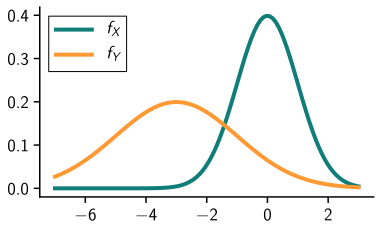

In [3]:
# Plot of probability density functions of X and Y
xx = np.linspace(-7, 3, num=100)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 3.5))
axes.plot(xx, X.distribution.pdf(xx), label="$f_X$", linewidth=4)
axes.plot(xx, Y.distribution.pdf(xx), label="$f_Y$", linewidth=4)
axes.legend()
plt.show()

## Arithmetic Operations

Perform basic arithmetic operations (addition, multiplication, ...) between scalars or vectors and random variables. You can also apply linear transformations and make use of broadcasting.

### Vectors and Matrices

In [4]:
# Affine transformation of a random variable
A = np.array([[1, 2], 
              [3, 2]])
X = RandomVariable(distribution=Normal(mean=np.array([1, 2]), cov=np.array([[5, 0], 
                                                                            [0, 2]])))
Y = A @ (- X) + np.array([1, 2])
print(Y)

<(2,) RandomVariable with dtype=<class 'float'>>


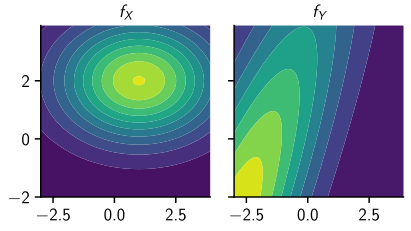

In [5]:
# Contour plot of the probability density functions of X and Y
delta = 0.1
uu = np.arange(-3, 4, delta)
vv = np.arange(-2, 4, delta)
U, V = np.meshgrid(uu, vv)

rvdict = {"$f_X$" : X, "$f_Y$" : Y}
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3.5), sharey=True)
for i, (title, rv) in enumerate(rvdict.items()):
    axes[i].contourf(U, V, rv.distribution.pdf(np.dstack((U, V))), levels=10)
    axes[i].title.set_text(title)
plt.tight_layout()

### Linear Operators

In [6]:
from probnum.linalg.linops import aslinop

# Linear operators applied to random variables
A = aslinop(np.array([[1, 2], 
                      [2, 4],
                      [-1, 0]]))
Y = A @ X

# Broadcasting
Y = Y + 1
print(Y.distribution.parameters)

{'mean': array([ 6, 11,  0]), 'cov': array([[ 13,  26,  -5],
       [ 26,  52, -10],
       [ -5, -10,   5]])}


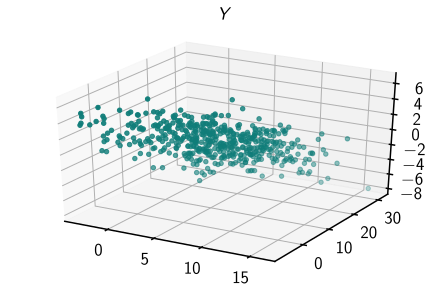

In [7]:
# Scatter plot
from mpl_toolkits.mplot3d import Axes3D

s = Y.sample(500)

fig = plt.figure(figsize=(6, 3.5))
ax = Axes3D(fig)
ax.scatter(s[:, 0], s[:, 1], s[:, 2])
ax.title.set_text("$Y$")

## Matrix-variate Random Variables

Matrix-variate random variables are used to model matrices probabilistically. They often arise in the case of dependent data tabulated in the form of a matrix. In the probabilistic numerics context they arise when the inverse of a linear operator is inferred. Here, we sample from a matrix-variate normal distribution
$$
\mathsf{X} \sim \mathcal{N}(M, V \otimes W)
$$

with a Kronecker product covariance.

In [8]:
from probnum.linalg.linops import Kronecker

# Matrix-variate normal distribution
n = 10
np.random.seed(1)
mean = np.vander(x=np.linspace(1, 0.1, n), N=n, increasing=True)
cov = Kronecker(A=0.1 * np.eye(n), B=0.1 * np.eye(n))
X = RandomVariable(distribution=Normal(mean=mean, cov=cov))

# Draw samples
Xsamples = X.sample(3)
print(Xsamples.shape)

(3, 10, 10)


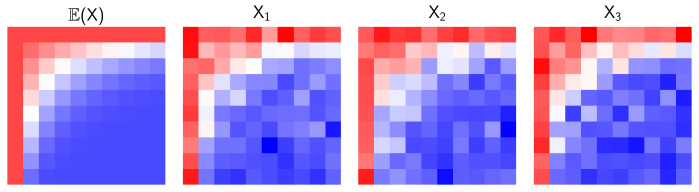

In [9]:
# Plot of mean and samples
rvdict = {"$\mathbb{E}(\mathsf{X})$" : X.mean(), "$\mathsf{X}_1$" : Xsamples[0], "$\mathsf{X}_2$" : Xsamples[1], 
          "$\mathsf{X}_3$" : Xsamples[2]}
vmin = np.min([np.min(mat) for mat in list(rvdict.values())])
vmax = np.max([np.max(mat) for mat in list(rvdict.values())])

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3.5), sharey=True)
for i, (title, rv) in enumerate(rvdict.items()):
    axes[i].imshow(rv, vmin=vmin, vmax=vmax, cmap="bwr")
    axes[i].set_axis_off()
    axes[i].title.set_text(title)
plt.tight_layout()

We will now take a closer look at the covariance. If it has Kronecker structure $V \otimes W$, then $V$ denotes the covariance among rows of the matrix and $W$ the covariance of the columns.

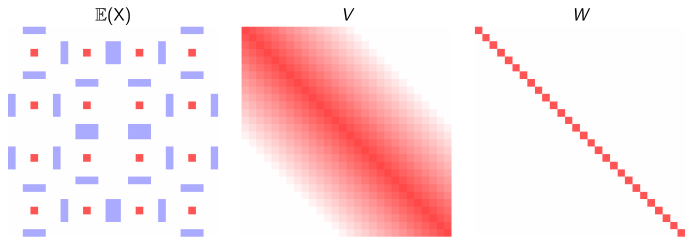

In [10]:
from scipy.sparse import diags

# Recursively structured mean matrix
def recursive_block_mat(k):
    if k == 0:
        arr = np.zeros((7, 7))
        arr[3, 3] = 1
        arr[6, 2:5] = arr[0, 2:5] = - 0.5
        return arr
    else:
        bl = recursive_block_mat(k - 1)
        return np.block([[bl.T, bl  ],
                         [bl  , bl.T]])
    
mean = recursive_block_mat(2)

# Kronecker covariance
n = mean.shape[0]
k = int(n/2)
V = 1 / k * diags(np.concatenate([np.arange(1, k + 1), np.arange(k + 1, 0, step=-1)]), 
                  np.arange(-k, k + 1), shape=(n, n)).toarray()  # row covariance
W = np.eye(n)  # column covariance
cov = Kronecker(V, W)

# Plot parameters
matdict = {"$\mathbb{E}(\mathsf{X})$" : mean, "$V$" : V, "$W$" : W}
vmax = 1.5

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5), sharey=True)
for i, (title, rv) in enumerate(matdict.items()):
    axes[i].imshow(rv, cmap='bwr', vmin=-vmax, vmax=vmax)
    axes[i].set_axis_off()
    axes[i].title.set_text(title)
plt.tight_layout()

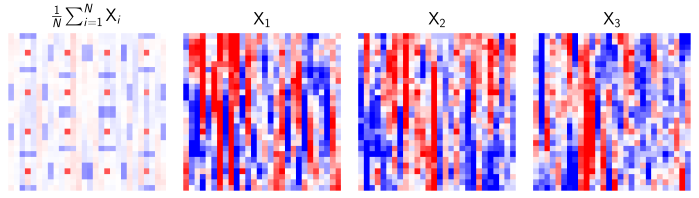

In [11]:
# Define random variable and draw samples
X = RandomVariable(distribution=Normal(mean=mean, cov=cov))
N = 100
Xsamples = X.sample(N)

# Plot samples
rvdict = {"$\\frac{{1}}{{N}} \sum_{i=1}^N \mathsf{X}_i$" : np.mean(Xsamples, axis=0),
          "$\mathsf{X}_1$" : Xsamples[0], "$\mathsf{X}_2$" : Xsamples[1], "$\mathsf{X}_3$" : Xsamples[2]}

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3.5), sharey=True)
for i, (title, rv) in enumerate(rvdict.items()):
    axes[i].imshow(rv, cmap='bwr', vmin=-vmax, vmax=vmax)
    axes[i].set_axis_off()
    axes[i].title.set_text(title)
plt.tight_layout()

We can see how the banded structure in $V$ induces samples with similar rows within a certain range given by the width of the band.